<a href="https://colab.research.google.com/github/a-matson/DST_ASS1/blob/main/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To-do



* Research, discuss and select performance metrics - ALL
* Introduce the dataset - ?
* EDA - Josh
* Everyone do their model experiments
  * Logistic regression - Geraint
  * SVM - Andre
  * Neural networks - Ethan
  * Decision trees - Josh
* Summary/conclusion - ?



# Introduction

Cite introductory paper for dataset: https://www.semanticscholar.org/paper/Nuclear-feature-extraction-for-breast-tumor-Street-Wolberg/53f0fbb425bc14468eb3bf96b2e1d41ba8087f36

All samples are taken from breast tumours. For each sample (fine needle aspirate), they use computer vision techniques to identify all of the cell nuclei and compute 10 features for each nucleus. The dataset contains, for each sample, the mean, largest (or 'worst') and standard error of each feature.

https://ftp.cs.wisc.edu/math-prog/cpo-dataset/machine-learn/cancer/WDBC/WDBC.dat

# Performance metrics

As researched (and discussed in dataset paper), medical performance metrics are sensitivity and specificity.

Our primary goal will be maximising sensitivity values but we will also report specificity/ ROC curves/ accuracy etc.

This is because we want to penalise false negatives as much as possible, as missing a cancer diagnosis is potentially fatal.

# Imports and setting up dataset

In [1]:
!pip install ucimlrepo

In [32]:
import sklearn as sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree

import matplotlib.gridspec as gridspec # subplots
%matplotlib inline


In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

y['Diagnosis'] = y['Diagnosis'].map({'M':0, 'B':1})

# metadata
#print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
#print(breast_cancer_wisconsin_diagnostic.variables)

<ipython-input-3-411e26e520e5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Diagnosis'] = y['Diagnosis'].map({'M':0, 'B':1})


In [4]:
column_name_mapping = {
    "radius1": "radius_mean",
    "texture1": "texture_mean",
    "perimeter1": "perimeter_mean",
    "area1": "area_mean",
    "smoothness1": "smoothness_mean",
    "compactness1": "compactness_mean",
    "concavity1": "concavity_mean",
    "concave_points1": "concave points_mean",
    "symmetry1": "symmetry_mean",
    "fractal_dimension1": "fractal_dimension_mean",
    "radius2": "radius_se",
    "texture2": "texture_se",
    "perimeter2": "perimeter_se",
    "area2": "area_se",
    "smoothness2": "smoothness_se",
    "compactness2": "compactness_se",
    "concavity2": "concavity_se",
    "concave_points2": "concave points_se",
    "symmetry2": "symmetry_se",
    "fractal_dimension2": "fractal_dimension_se",
    "radius3": "radius_worst",
    "texture3": "texture_worst",
    "perimeter3": "perimeter_worst",
    "area3": "area_worst",
    "smoothness3": "smoothness_worst",
    "compactness3": "compactness_worst",
    "concavity3": "concavity_worst",
    "concave_points3": "concave points_worst",
    "symmetry3": "symmetry_worst",
    "fractal_dimension3": "fractal_dimension_worst",
}


In [5]:
# Rename columns

X = X.rename(columns=column_name_mapping)
X.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [6]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [7]:
X_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
342,11.06,14.96,71.49,373.9,0.10330,0.09097,0.05397,0.03341,0.1776,0.06907,...,11.92,19.90,79.76,440.0,0.1418,0.2210,0.2299,0.10750,0.3301,0.09080
138,14.95,17.57,96.85,678.1,0.11670,0.13050,0.15390,0.08624,0.1957,0.06216,...,18.55,21.43,121.40,971.4,0.1411,0.2164,0.3355,0.16670,0.3414,0.07147
434,14.86,16.94,94.89,673.7,0.08924,0.07074,0.03346,0.02877,0.1573,0.05703,...,16.31,20.54,102.30,777.5,0.1218,0.1550,0.1220,0.07971,0.2525,0.06827
47,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,...,15.67,27.95,102.80,759.4,0.1786,0.4166,0.5006,0.20880,0.3900,0.11790
64,12.68,23.84,82.69,499.0,0.11220,0.12620,0.11280,0.06873,0.1905,0.06590,...,17.09,33.47,111.80,888.3,0.1851,0.4061,0.4024,0.17160,0.3383,0.10310


In [8]:
y_train.head()

,Diagnosis
342,1
138,0
434,1
47,0
64,0


# Useful functions

In [111]:
def performance(confusion_matrix):
    [[TN, FP] , [FN, TP]] = confusion_matrix.tolist()
    P = TP + FN
    N = TN + FP
    sens = TP / P
    spec = TN / N
    acc = (TP + TN) / (P + N)
    print(f"Accuracy = {acc}")
    print(f"Sensitivity = {sens}")
    print(f"Specificity = {spec}")
    return

# Andre

Structure:
- state high correlation (which is expected with variable relation)
- consider ratio of diagnoses M vs B
- Look at y's spread (boxplot or something more sophisticated like violin plot which may be the most appropriate)
- This can lead to conclusion based on bivariate distributions with diagnosis that larger values correlate with getting diagnose as M.
- This in turn allows us to evaluate variables that aren't strongly correlated with the outcome. (which are: `'fractal_dimension_mean', 'texture_se', 'smoothness_se', 'symmetry_se', 'fractal_dimension_se'`)
- We can test feature relationship with the target variable by using one-way ANOVA (but this may be excessive since visualisation already show significant idications)
- There is a lot of difference in terms of the scales of the predictors. (ie the area and perimeter) This requires us to normalise data.
- Analyse data... (31 predictors)
- This data highly dimensional and highly correlated within predictors
- Logistic regression may be used (since there's not much data but a lot of features)
- Maybe justify in more details what corrections could be used to improve its predictions
- SVC is less sensitive to multicollinearity.


"VIF measures the extent to which each predictor is estimateable by the other predictors, measuring the extent of linear dependence of each predictor by the others. We use the function from statsmodels"

### weak predictors

In [28]:
corr = X.corr().iloc[0,][1:]
corr[corr < 0.1]


fractal_dimension_mean    -0.311631
texture_se                -0.097317
smoothness_se             -0.222600
symmetry_se               -0.104321
fractal_dimension_se      -0.042641
fractal_dimension_worst    0.007066
Name: radius_mean, dtype: float64

We can succesfully predict the target using many predictors with very low correlation. If predictors are not too correlated amongst themselves (so that they are not duplicating information too much), they will tend to add information to the regression even if they are individually adding only a small amount of information. With a sufficient number of (individually) weak predictors you can make a prediction of the response variable that is highly accurate. The overall accuracy is somewhat complicated --- in linear regression it depends on the full correlation matrix of the predictors and their individual correlations with the response variable (see O'Neill 2019 for a geometric analysis).

### Scale data

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

testing scaling on logistic regression

In [31]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
pred_lr = lr.predict(X_test_scaled)
print(classification_report(y_test, pred_lr, target_names=['M', 'B']))

              precision    recall  f1-score   support

           M       0.89      1.00      0.94        34
           B       1.00      0.95      0.97        80

    accuracy                           0.96       114
   macro avg       0.95      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## SMV

A Support Vector Machine (SVM) determines the optimal hyperplane to divide classes. It is achieved by maximising the gap between the decision boundary and each class of points. For linear classfier of our two class data we can have infinite many decision boundaries between classes.

This algorithm is very efficienta as instead of looking at all the data points, SVM focuses on just a few key ones known as support vectors, which are the data points closest to the dividing line. These support vectors guide SVM in choosing the best possible dividing line.

To achieve this, we use an cost function. This function represents the gap between the data points and the dividing line. We strive to maximize this gap, which means we aim to minimize something called hinge loss. Hinge loss measures how far a point is from the dividing line when it's wrongly classified.

For our dataset of sample size 569 with 31 numeric predictors without encoding, Support Vector Machine (SVM) is fitting model because:
1. SVM is more effective in high dimensional spaces;
2. SVM are less likely to overfit to training data as less sensative to outliers than logistic regression;
2. SVM is less sensitive to multicollinbearity. In particular we will consider non-linear SVMs.:

As well as, all of the disadvantages are avoided as:
1. Dataset is not large;
2. Number of features for each data point doesn't exceed the number of training data samples ie SVM won't underpreform;
3. Data set is not too noisy and target classes are not overlapping.

In [35]:
from sklearn.svm import SVC, LinearSVC

There's two different implmentations of linear svc `LinearSVC` and `SVC(kernel='linear')` which differ based on implementation (ie liblinear and libsvm respectively) [elaborate]

"The main differences between LinearSVC and SVC lie in the loss function used by default, and in the handling of intercept regularization between those two implementations." from documentation.

In [114]:
lin_svc = LinearSVC()
grid_svc = GridSearchCV(lin_svc, {'C':[1, .1, .01, .001]}, cv=4) # GridSearchCV rely on an internal scoring strategy
grid_svc.fit(X_train_scaled, y_train.values.ravel())
print("Best C:", grid_svc.best_params_)
print("Best train score:", grid_svc.best_score_)

Best C: {'C': 0.01}
Best train score: 0.9780119546654247


Optimising for the best C parameter and the type of kernel [elaborate on kernels and hyperparam C]

In [87]:
params_svc = {
    'C': [1, .1, .01, .001],
    'kernel': ['linear', 'poly', 'rbf']
}

Improve on scoring -> use metric we agreed

In [132]:
from sklearn.metrics import accuracy_score, make_scorer

def calculations(y_test, pred_svc):
    [[TN, FP] , [FN, TP]] = confusion_matrix(y_test, pred_best_svc).tolist()
    P = TP + FN
    N = TN + FP
    return P, N, TN, FP, FN, TP

def matric_sensitivity(y_test, pred_svc):
    [P,_,_,_,_,TP] = calculations(y_test, pred_svc)
    return TP / P

def matric_specificity(y_test, pred_svc):
    [_,N,TN,_,_,_] = calculations(y_test, pred_svc)
    return TN / N

def matric_accuracy(y_test, pred_svc):
    [P,N,TN,_,_,TP] = calculations(y_test, pred_svc)
    return (TP + TN) / (P + N)

scoring = {
    "Accuracy": make_scorer(matric_accuracy),
    "Sensitivity": make_scorer(matric_sensitivity),
    "Specificity": make_scorer(matric_specificity),
}

In [142]:
lin_svc = LinearSVC()
grid_svc = GridSearchCV(lin_svc, {'C':[1, .1, .01, .001]}, cv=4, scoring='recall', return_train_score=True)
grid_svc.fit(X_train_scaled, y_train.values.ravel())
print("Best C:", grid_svc.best_params_)
print("Best train score:", grid_svc.best_score_)

Best C: {'C': 0.01}
Best train score: 0.9928053830227743


In [147]:
def gridSearch(scoring):
  grid_svc = GridSearchCV(SVC(), params_svc, scoring=scoring, cv=15)
  grid_svc.fit(X_train_scaled, y_train.values.ravel())
  print("Best C:", grid_svc.best_params_)
  print("Best train score:", grid_svc.best_score_)
  cv_results = grid_svc.cv_results_

  scores_mean = np.array(cv_results['mean_test_score']).reshape(len(params_svc['kernel']),len(params_svc['C']))
  scores_sd = np.array(cv_results['std_test_score']).reshape(len(params_svc['kernel']),len(params_svc['C']))

  # Plot Grid search scores
  _, ax = plt.subplots(1,1)

  xaxis = np.log(params_svc['C']) # scale x-axis

  # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
  for idx, val in enumerate(params_svc['kernel']):
      ax.plot(xaxis, scores_mean[idx,:], '-o', label= f'kernel {val}')

  plt.xticks(xaxis, params_svc['C'])
  ax.set_title("Grid Search Scores")
  ax.legend()
  # plt.xticks([for x in params_svc[]])
  ax.grid('on')
  return grid_svc

Best C: {'C': 0.1, 'kernel': 'linear'}
Best train score: 0.9801433691756273


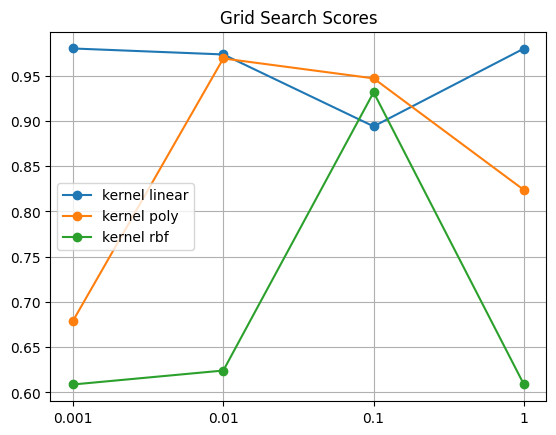

In [148]:
grid_svc_acc = gridSearch('accuracy')

Best C: {'C': 1, 'kernel': 'poly'}
Best train score: 1.0


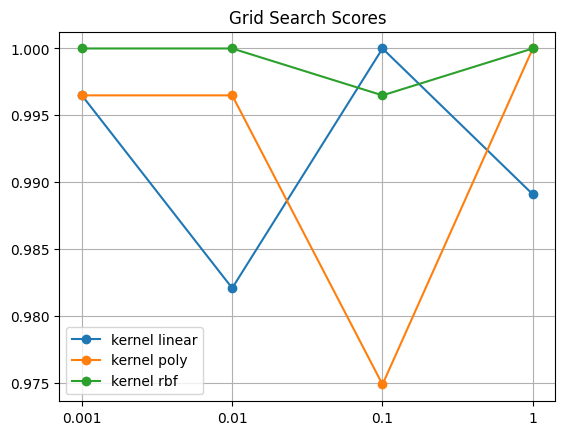

In [149]:
grid_svc_recall = gridSearch('recall')

Best C: {'C': 1, 'kernel': 'linear'}
Best train score: 0.9794736842105264


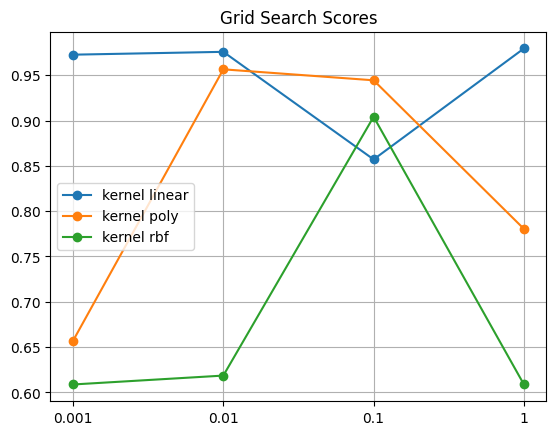

In [150]:
grid_svc_precision = gridSearch('precision')

Write up on the results

Best score is achieved with linear kernal with `C=0.1`.

In [151]:
best_svc = SVC(**grid_svc.best_params_)
best_svc.fit(X_train_scaled, y_train)
pred_best_svc = best_svc.predict(X_test)
performance(confusion_matrix(y_test, pred_best_svc))
print(classification_report(y_test, pred_best_svc, target_names=['M', 'B']))

Accuracy = 0.7017543859649122
Sensitivity = 1.0
Specificity = 0.0
              precision    recall  f1-score   support

           M       0.00      0.00      0.00        34
           B       0.70      1.00      0.82        80

    accuracy                           0.70       114
   macro avg       0.35      0.50      0.41       114
weighted avg       0.49      0.70      0.58       114



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [152]:
svc_rbf = SVC()
svc_rbf.fit(X_train_scaled, y_train)
pred_svc_rbf = svc_rbf.predict(X_test_scaled)
print(classification_report(y_test, pred_svc_rbf, target_names=['M', 'B']))

              precision    recall  f1-score   support

           M       0.92      1.00      0.96        34
           B       1.00      0.96      0.98        80

    accuracy                           0.97       114
   macro avg       0.96      0.98      0.97       114
weighted avg       0.98      0.97      0.97       114



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Ethan



*   Do 4 or 5 fold cross-val for hyperparameter optimisation of neural networks
*   Hyperparameters include
  * Model architecture - number of layers and number of hidden units
  * Use of dropout or not
  * Use of batch norm or other normalisation techniques
  * Different activation functions
  * Optimizer and with/without weight decay
  * Loss function used
  * Regularization

* From cross-val, select best parameters for different reasons, retrain on entire training data and hopefully get conducive results, if not will be down to stochasiticity of small dataset

Due to 114 test samples, only a fixed number of possible output test accuracies which is why we see exact same accuracies reported

Potential conclusion: dataset relatively simple in context of what NNs are used for, so not much need for bigger architectures or extra features to push performance. NNs really for larger more complex data

https://gist.github.com/Guitaricet/28fbb2a753b1bb888ef0b2731c03c031

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
def calculate_sensitivity(y_true, y_pred):
    true_positive = ((y_pred == 1) & (y_true == 1)).sum().item()
    actual_positive = (y_true == 1).sum().item()
    sensitivity = true_positive / actual_positive if actual_positive > 0 else 0
    return sensitivity

In [ ]:
# Define your neural network model
class SimpleNN(nn.Module):
    def __init__(self, num_layers, hidden_sizes):
        super(SimpleNN, self).__init__()
        self.layers = []
        prev_layer_size = 30
        for i in range(num_layers):
            self.layers.append(nn.Linear(prev_layer_size, hidden_sizes[i]))
            self.layers.append(nn.ReLU())
            prev_layer_size = hidden_sizes[i]
        self.layers.append(nn.Linear(prev_layer_size, 1))
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

In [ ]:
fix_seed()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train_tensor):

  X_train_cv, X_val_cv = X_train_tensor[train_index], X_train_tensor[val_index]
  y_train_cv, y_val_cv = y_train_tensor[train_index], y_train_tensor[val_index]

  model = SimpleNN(1, [4])

  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  best_sensitivity = 0
  best_epoch = 0

  for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    output = model(X_train_cv)
    loss = criterion(output, y_train_cv.view(-1,1))

    loss.backward()
    optimizer.step()

    with torch.no_grad():
      val_output = model(X_val_cv)
      val_loss = criterion(val_output, y_val_cv.view(-1, 1))
      predicted_labels = (val_output > 0.5).float()
      # val_acc = (predicted_labels == y_val_cv.view(-1, 1)).float().mean()
      # if val_acc >= best_sensitivity:
      #   best_sensitivity = val_acc
      #   best_epoch = epoch
      sensitivity = calculate_sensitivity(y_val_cv, predicted_labels)
      if sensitivity > best_sensitivity:
        best_sensitivity = sensitivity
        best_epoch = epoch

  print(best_sensitivity, best_epoch)
  print(sensitivity, epoch)

1.0 25
1.0 499
0.9245283018867925 406
0.9245283018867925 499
0.9821428571428571 114
0.9642857142857143 499
0.9259259259259259 443
0.9259259259259259 499
0.9622641509433962 383
0.9622641509433962 499


Trying to tune epochs as a hyperparameter does not really work, as we find that it is highly dependent on the specific data split - one such split may get very lucky in producing quicker convergence, this does not tell us much about how a different split may behave. So let us train for a fixed number of epochs going forward, say 500, and investigate different changes to the model.

In [ ]:
num_layers = [2, 3, 5]
hidden_sizes_lists = [[4]*n for n in num_layers]

[[4, 4], [4, 4, 4], [4, 4, 4, 4, 4]]

In [ ]:
for n, hidden_sizes in zip(num_layers, hidden_sizes_lists):
  print(n, hidden_sizes)
  fix_seed()
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  for train_index, val_index in kf.split(X_train_tensor):

    X_train_cv, X_val_cv = X_train_tensor[train_index], X_train_tensor[val_index]
    y_train_cv, y_val_cv = y_train_tensor[train_index], y_train_tensor[val_index]

    model = SimpleNN(n, hidden_sizes)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_sensitivity = 0
    best_epoch = 0

    for epoch in range(500):
      model.train()
      optimizer.zero_grad()

      output = model(X_train_cv)
      loss = criterion(output, y_train_cv.view(-1,1))

      loss.backward()
      optimizer.step()

    with torch.no_grad():
      val_output = model(X_val_cv)
      val_loss = criterion(val_output, y_val_cv.view(-1, 1))
      predicted_labels = (val_output > 0.5).float()
      # val_acc = (predicted_labels == y_val_cv.view(-1, 1)).float().mean()
      # if val_acc >= best_sensitivity:
      #   best_sensitivity = val_acc
      #   best_epoch = epoch
      sensitivity = calculate_sensitivity(y_val_cv, predicted_labels)
      if sensitivity > best_sensitivity:
        best_sensitivity = sensitivity
        best_epoch = epoch

    print(best_sensitivity, best_epoch)
    #print(sensitivity, epoch)

2 [4, 4]
1.0 499
0.9811320754716981 499
0.9642857142857143 499
1.0 499
0.9811320754716981 499
3 [4, 4, 4]
1.0 499
0.9811320754716981 499
0.9821428571428571 499
0.9814814814814815 499
0.9811320754716981 499
5 [4, 4, 4, 4, 4]
1.0 499
1.0 499
0.9642857142857143 499
0.9814814814814815 499
1.0 499


In [ ]:
type(y_train)

pandas.core.frame.DataFrame

tensor([0.])


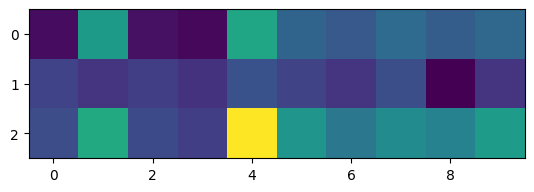

In [ ]:
i=4
plt.imshow(X_train_tensor[i].reshape((3,10)))
print(y_train_tensor[i])

In [ ]:
import torch
import random
import numpy as np

def fix_seed():

  # Set seeds for reproducibility
  seed_value = 42

  # 1. Set the seed for Python's built-in random number generator
  random.seed(seed_value)

  # 2. Set the seed for NumPy
  np.random.seed(seed_value)

  # 3. Set the seed for PyTorch
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
fix_seed()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        h = 32
        self.fc1 = nn.Linear(X_train.shape[1], h)
        self.fc2 = nn.Linear(h, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model
model = Net()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 350
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()

# Evaluate the model on the test data
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor.view(-1, 1))
    predicted_labels = (test_output > 0.5).float()
    test_acc = (predicted_labels == y_test_tensor.view(-1, 1)).float().mean()

print(f'Test accuracy: {test_acc.item()}')

Test accuracy: 0.9736841917037964


In [ ]:
108/114

0.9473684210526315

In [ ]:
y_test_tensor.shape

torch.Size([114, 1])

In [ ]:
fix_seed()

# Define the neural network model with dropout
class NetWithDropout(nn.Module):
    def __init__(self):
        super(NetWithDropout, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 32)
        self.dropout = nn.Dropout(0)  # Adjust dropout rate as needed
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model
model_with_dropout = NetWithDropout()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_with_dropout.parameters(), lr=0.001)

# Training the model with dropout
epochs = 100
for epoch in range(epochs):
    model_with_dropout.train()
    optimizer.zero_grad()
    output = model_with_dropout(X_train_tensor)
    loss = criterion(output, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()

# Evaluate the model with dropout on the test data
model_with_dropout.eval()
with torch.no_grad():
    test_output = model_with_dropout(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor.view(-1, 1))
    predicted_labels = (test_output > 0.5).float()
    test_acc = (predicted_labels == y_test_tensor.view(-1, 1)).float().mean()

print(f'Test accuracy with dropout: {test_acc.item()}')

Test accuracy with dropout: 0.9473684430122375


In [ ]:
fix_seed()

# Define the neural network model with dropout and batch normalization
class NetWithDropoutBN(nn.Module):
    def __init__(self):
        super(NetWithDropoutBN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 32)
        self.bn1 = nn.BatchNorm1d(32)  # Batch normalization after the first fully connected layer
        #self.dropout = nn.Dropout(0.5)  # Adjust dropout rate as needed
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))  # Apply batch normalization before activation
        #x = self.dropout(x)  # Apply dropout
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model with dropout and batch normalization
model_with_dropout_bn = NetWithDropoutBN()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_with_dropout_bn.parameters(), lr=0.001)

# Training the model with dropout and batch normalization
epochs = 100
for epoch in range(epochs):
    model_with_dropout_bn.train()
    optimizer.zero_grad()
    output = model_with_dropout_bn(X_train_tensor)
    loss = criterion(output, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()

# Evaluate the model with dropout and batch normalization on the test data
model_with_dropout_bn.eval()
with torch.no_grad():
    test_output = model_with_dropout_bn(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor.view(-1, 1))
    predicted_labels = (test_output > 0.5).float()
    test_acc = (predicted_labels == y_test_tensor.view(-1, 1)).float().mean()

print(f'Test accuracy with dropout and batch normalization: {test_acc.item()}')

Test accuracy with dropout and batch normalization: 0.9649122953414917


In [ ]:
fix_seed()

# Define the neural network model with more layers
class NetWithMoreLayers(nn.Module):
    def __init__(self):
        super(NetWithMoreLayers, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Initialize the model with more layers
model_with_more_layers = NetWithMoreLayers()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_with_more_layers.parameters(), lr=0.001)

# Training the model with more layers
epochs = 500
for epoch in range(epochs):
    model_with_more_layers.train()
    optimizer.zero_grad()
    output = model_with_more_layers(X_train_tensor)
    loss = criterion(output, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()


model_with_more_layers.eval()
with torch.no_grad():
    test_output = model_with_more_layers(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor.view(-1, 1))
    predicted_labels = (test_output > 0.5).float()
    test_acc = (predicted_labels == y_test_tensor.view(-1, 1)).float().mean()

print(f'Test accuracy with more layers: {test_acc.item()}')

Test accuracy with more layers: 0.9824561476707458


In [ ]:
fix_seed()

# Define the neural network model with more layers and L2 regularization
class NetWithRegularization(nn.Module):
    def __init__(self):
        super(NetWithRegularization, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Initialize the model with L2 regularization
model_with_regularization = NetWithRegularization()

# Define the loss function and optimizer with L2 regularization
criterion = nn.BCELoss()
optimizer = optim.Adam(model_with_regularization.parameters(), lr=0.001)  # Adjust weight decay as needed

# Training the model with L2 regularization
epochs = 300
for epoch in range(epochs):
    model_with_regularization.train()
    optimizer.zero_grad()
    output = model_with_regularization(X_train_tensor)
    loss = criterion(output, y_train_tensor.view(-1, 1))

    # Add L2 regularization to the loss
    l2_lambda = 0.01  # Adjust the regularization strength
    l2_reg = torch.tensor(0.)
    for param in model_with_regularization.parameters():
        l2_reg += torch.norm(param)
    loss += l2_lambda * l2_reg

    loss.backward()
    optimizer.step()

# Evaluate the model with L2 regularization on the test data
model_with_regularization.eval()
with torch.no_grad():
    test_output = model_with_regularization(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor.view(-1, 1))
    predicted_labels = (test_output > 0.5).float()
    test_acc = (predicted_labels == y_test_tensor.view(-1, 1)).float().mean()

print(f'Test accuracy with L2 regularization: {test_acc.item()}')

Test accuracy with L2 regularization: 0.9912280440330505


#Josh

Here we create a scaled version of the data. We do this to compare model performance with scaled versus raw data.



In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

I would like to see if there are any features which show a high correlation to the Diagnonsis target variable. To do so we conbtruct a correlation heatmap and select the diagnonsis column

In [ ]:
data = pd.concat([X , y] , axis = 1)
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
cor_target = abs(corr["Diagnosis"])
relevant_features = abs(corr["Diagnosis"]).sort_values(ascending=False).drop('Diagnosis')
print('A sorted list of the correlation between each variable and the target variable')
print(relevant_features)

We select all features with a high correlation to the target variable (>0.5).

In [ ]:
ten_relevant_features = relevant_features[0:15]
names = ten_relevant_features.keys()
print('A sorted list of the variables with >0.5 correlation')
print(ten_relevant_features)

We would like to further remove variables with high correlation between themselves as we assume they contain similar information.

In [ ]:
X_relevant = X[names]
corr2 = X_relevant.corr()
corr2.style.background_gradient(cmap='coolwarm')

From the above heatmap, we decide to replace :



*   radius_worst, perimeter_mean, area_worst, radius_mean, area_mean with radius_worst
*   radius_se, perimeter_se, area_se with radius_se

We do this as they share high correlation with each other and radius_worst and radius_se have the best correlation with the target within these groups.

In [ ]:
def performanceJ(confusion_matrix):
    [[TN, FP] , [FN, TP]] = confusion_matrix.tolist()
    P = TP + FN
    N = TN + FP
    sens = TP / P
    spec = TN / N
    acc = (TP + TN) / (P + N)
    accurancy =  str(acc)
    sensitivity =  str(sens)
    specificity =  str(spec)
    return accurancy, sensitivity,specificity

Above we introduce a performance calculator, we are looking to find the best sensitivity. We include accuracy and specificity for interest.

In [ ]:
X_relevant_dropped = X_relevant.drop(columns=['perimeter_mean','area_worst','radius_mean','area_mean'])

Below we create 6 models. Basic decision trees and random forests with both scaled and uncscaled data, and a decision tree with optimal parameters.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print(cm)
perf_cm =performance(cm)

Above is the most basic Decision tree we can make. We will use this to swet a 'base-line' we hope to improve.

In [ ]:
model_sc = DecisionTreeClassifier()
model_sc.fit(X_train_scaled, y_train)
predictions_sc = model_sc.predict(X_test_scaled)
cm_sc = confusion_matrix(y_test, predictions_sc)
print(cm_sc)
perf_sc = performance(cm_sc)

A common technique for improving model performance is to scale the data. This is because data on different scales can affect models on different scales. Thus by normalising the features we hope to be able to extract more information from features which vary less.

In [ ]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
predictions_rf = model.predict(X_test)
cm_rf = confusion_matrix(y_test, predictions_rf)
print(cm_rf)
perf_rf = performance(cm_rf)

Random forests can be used to increase performance of decision trees by attempting to solve the issue of overfitting.

In [ ]:
model_rf_scaled = RandomForestClassifier()
model_rf_scaled.fit(X_train_scaled, y_train)
predictions_rf_scaled = model.predict(X_test)
cm_rf_sc = confusion_matrix(y_test, predictions_rf_scaled)
print(cm_rf_sc)
perf_rf_sc = performance(cm_rf_sc)

Above we again introduce the scaled data to hope for an improvement in performance.

We would now like to tune the hyperparameters of the decision tree and random forest model. To do this we introduce the GridSearchCV, which takes an input of the model itself and a dictionary of possible parameters. It then performs cross-validation on every possible combination of parameters given in the dictionary and stores the optimal values.

It should be noted that this method requires the creation of many many models. For example in the random forest parameter search there are 3*4*4*2*3*3*2 = 1728 models to be made with a 5-fold cross-validation being done. This results in 8640 models being ran, which is obviously extremely computationly expensive. In fact even for our moderately small dataset, whith singular models running almost instantly, the random forest grid search takes almost 22 minuites.

For the decision tree we try all possible measures of fit in sklearn (gini,entropy,log_loss).
Max_features controls how much of the data is seen when performing splits, which can help with overfitting.
ccp_alpha is used to adjust the sensitivity of miniml cost-pruning.
max_depth is used to control the complexity of the model, limiting the depth can help prevent overfitting.

In [ ]:
par_dtc = {'criterion':['gini', 'entropy', 'log_loss'],
           'max_depth':[2,4,6,8],
           'min_samples_split':[2,4,6,8],
          'max_features': ['auto', 'sqrt', 'log2'],
          'ccp_alpha': [0.1, 0.01, 0.001]}
gcv_dtc = GridSearchCV(estimator=model_sc, param_grid=par_dtc, cv=5, verbose=1)
gcv_dtc.fit(X_train_scaled, y_train)

For the random forest model we again test all criterion along with a selection of ccp_alpha, max_features, max_depth and min_samples_split values.
We also add the min_samples_leaf field to test. This is because with min_samples_leaf=2 we would expect a smoothing effect of the resulting trees, this could cause models which combine together in a random forest better.
We also would like to see if bootstrapping affects performance, so we add it to the parameter list.

In [ ]:
par_rtc = {'criterion':['gini', 'entropy', 'log_loss'],
           'max_depth':[2,4,6,8],
           'min_samples_split':[2,4,6,8],
           'min_samples_leaf':[1,2],
          'max_features': ['auto', 'sqrt', 'log2'],
          'ccp_alpha': [0.1, 0.01, 0.001],
           'bootstrap': [True,False]}
gcv_rtc = GridSearchCV(estimator=model_rf_scaled, param_grid=par_rtc, cv=5, verbose=1)
gcv_rtc.fit(X_train_scaled, y_train)

We extract the best parameters below and fit an according model to each.

In [ ]:
gcv_rtc.best_params_

In [ ]:
gcv_dtc.best_params_

In [ ]:
rtc_new = RandomForestClassifier(ccp_alpha= 0.001,criterion= 'entropy',max_depth= 8,max_features= 'auto',min_samples_split=2,min_samples_leaf=1,bootstrap=False)

In [ ]:
model_sc_dt = DecisionTreeClassifier(ccp_alpha=0.01,criterion='entropy',max_depth= 6,max_features= 'auto',min_samples_split= 4)

In [ ]:
model_sc_dt.fit(X_train_scaled, y_train)
predictions_sc_dt = model_sc_dt.predict(X_test_scaled)
cm_sc_dt = confusion_matrix(y_test, predictions_sc_dt)
print(cm_sc_dt)
perf_sc_dt = performance(cm_sc_dt)

In [ ]:
rtc_new.fit(X_train_scaled, y_train)
pred_rtc = rtc_new.predict(X_test_scaled)
cm_rtc = confusion_matrix(y_test, pred_rtc)
print(cm_rtc)
perf_rtc = performance(cm_rtc)

In [ ]:

performancedf = {'Model Type': ['Standard Tree', 'Scaled data Tree','Scaled data Tree best Param','Random Rorest','Random Forest Scaled','RandomForest_best param'],
                 'Accurancy': [perf_cm[0],perf_sc[0],perf_sc_dt[0],perf_rf[0],perf_rf_sc[0],perf_rtc[0]],
                 'Sensitivity': [perf_cm[1],perf_sc[1],perf_sc_dt[1],perf_rf[1],perf_rf_sc[1],perf_rtc[1]],
                 'Specificity': [perf_cm[2],perf_sc[2],perf_sc_dt[2],perf_rf[2],perf_rf_sc[2],perf_rtc[2]]}
performancedf = pd.DataFrame(data=performancedf)
performancedf

We would alsp like to inspect the roc_auc_score. This measures the area underneath an roc curve, with 1 indicating perfect performance and 0.5 suggesting completely random guesses.

In [ ]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, predictions)
print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, predictions))

false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, predictions_sc)
print('roc_auc_score for DecisionTree with scaled data: ', roc_auc_score(y_test, predictions_sc))

false_positive_rate5, true_positive_rate5, threshold5 = roc_curve(y_test, predictions_sc_dt)
print('roc_auc_score for Decision Tree with parameters: ', roc_auc_score(y_test, predictions_sc_dt))

false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, predictions_rf)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, predictions_rf))

false_positive_rate6, true_positive_rate6, threshold6 = roc_curve(y_test, predictions_rf_scaled)
print('roc_auc_score for Random Forest with scaled data: ', roc_auc_score(y_test, predictions_rf_scaled))

false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(y_test, pred_rtc)
print('roc_auc_score for Random Forest with parameters: ', roc_auc_score(y_test, pred_rtc))

Below We use a slightly modified version of Andre's function run_model. I change it to look at sensitivity as we are interested in health data.

In [ ]:
def run_modelJ(model, X, y, n_splits=5, random_state=None):
    """
    Run a machine learning model with K-Fold cross-validation.

    Args:
        model: The machine learning model (e.g., LogisticRegression, RandomForestClassifier, etc.).
        X_data: The feature data.
        y_data: The target variable.
        n_splits (int): The number of cross-validation splits.
        random_state (int): Random seed for reproducibility.

    Returns:
        mean_sensitivity (float): Mean accuracy across all folds.
    """
    # Initialize the model
    ml_model = model

    # Initialize K-Fold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Lists to store cross-validation results
    sensitivity = []

    X_data = X
    y_data = y['Diagnosis']

    # Perform K-Fold cross-validation
    for train_idx, test_idx in kf.split(X_data):
        X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_train, y_test = y_data.iloc[train_idx], y_data.iloc[test_idx]

        # Fit the model on the training data
        ml_model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = ml_model.predict(X_test)

        # Calculate accuracy for this fold
        cf = confusion_matrix(y_test, y_pred)
        sens = performance(cf)[1]
        sens = float(sens)
        sensitivity.append(sens)

    # Calculate the mean accuracy across all folds
    mean_sensitivity = sum(sensitivity) / n_splits

    print(f"Sensitivities: {sensitivity}")
    print(f"Mean Sensitivity: {mean_sensitivity}")

    return mean_sensitivity

In [ ]:
print('Standard Decision Tree')
run_modelJ(model,X,y,random_state=4)
print('Standard Decision Tree with scaling')
run_modelJ(model_sc,X,y,random_state=4)
print('Decision Tree with scaling and parameters')
run_modelJ(model_sc_dt,X,y,5,random_state=4)
print('Random Forest')
run_modelJ(model_rf,X,y,5,random_state=4)
print('Random Forest with scaling')
run_modelJ(model_rf_scaled,X,y,5,random_state=4)
print('Random Forest with scaling and parameters')
run_modelJ(rtc_new,X,y,5,random_state=4)

As can be seen from the above results. The grid search was able to find parameters that improved both the decision tree and the random forest. Scaling seems to improve things, but it should be noted that the predicitons were already very good and improving these further would be difficult. However, 98% sensitivity is still a very good result.

Below we investigate the effect removing variables which were lowly correlated to the response variable and highly correlated to each other.

In [ ]:
print('Standard Decision Tree with Dropped Features')
run_modelJ(model,X_relevant_dropped,y,random_state=4)
print('Standard Decision Tree with scaling with Dropped Features')
run_modelJ(model_sc,X_relevant_dropped,y,random_state=4)
print('Decision Tree with scaling and parameters with Dropped Features')
run_modelJ(model_sc_dt,X_relevant_dropped,y,5,random_state=4)
print('Random Forest with Dropped Features')
run_modelJ(model_rf,X_relevant_dropped,y,5,random_state=4)
print('Random Forest with scaling with Dropped Features')
run_modelJ(model_rf_scaled,X_relevant_dropped,y,5,random_state=4)
print('Random Forest with scaling and parameters with Dropped Features')
run_modelJ(rtc_new,X_relevant_dropped,y,5,random_state=4)

It seems the data which had dropped features seems to perform on average slightly worse. This suggests to me that the data was not overfitting and most data held some value/ information regarding the target variable.

Despite the dropped variables being highly correlated with each other and lowly correlated with the traget variable, there was still some information to be gained by adding them in.

However, the model still performs with a sensitivity only a few percent lower for all models. This is remarkablw considering over half of the features were dropped. This does sugest the highly correlated variables shared alot of the information.

#Geraint

In [ ]:
data = pd.concat([X , y] , axis = 1)

In [ ]:
corr = data.corr()
#plt.figure(figsize=(20,20))
#sns.heatmap(corr, cmap='mako_r',annot=True)
#plt.show()

In [ ]:
#Now we want to collect highly correlated features (greater than a set threshold)
threshold = 0.2
cor_target = abs(corr["Diagnosis"])
relevant_features = cor_target[cor_target>threshold]
names = relevant_features.keys()
#drop the target feature from the list of 'highly' correlated features
names = names.drop('Diagnosis')
print(names)

Index(['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'radius2',
       'perimeter2', 'area2', 'compactness2', 'concavity2', 'concave_points2',
       'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3',
       'compactness3', 'concavity3', 'concave_points3', 'symmetry3',
       'fractal_dimension3'],
      dtype='object')


In [ ]:
#Set our train/test inputs to include only the features we care about
X_train1, X_test1 = X_train[names], X_test[names]
#Our model also requires our response vector to be a 1d array
y_train1, y_test1 = np.ravel(y_train), np.ravel(y_test)

In [ ]:
model = LogisticRegression()

In [ ]:
model.fit(X_train1, y_train1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
predictions = model.predict(X_test1)

In [ ]:
cm = confusion_matrix(y_test1, predictions)
print(cm)

[[30  4]
 [ 8 72]]


In [ ]:
performance(cm)

Accuracy = 0.8947368421052632
Sensitivity = 0.9
Specificity = 0.8823529411764706


In [ ]:
#we can see whether scaling our data will improve our model
sc = StandardScaler()
X_train1_sc = sc.fit_transform(X_train1)
X_test1_sc = sc.fit_transform(X_test1)
#assert abs(X_train1_sc.mean()) < 1e10 , abs(1 - X_train1_sc.std()) < 1e10
#assert abs(X_test1_sc.mean()) < 1e10 , abs(1 - X_test1_sc.std()) < 1e10

In [ ]:
model_sc = LogisticRegression()
model_sc.fit(X_train1_sc, y_train1)

LogisticRegression()

In [ ]:
predictions_sc = model_sc.predict(X_test1_sc)

In [ ]:
cm_sc = confusion_matrix(y_test1, predictions_sc)
print(cm_sc)

[[34  0]
 [ 5 75]]


In [ ]:
performance(cm_sc)

Accuracy = 0.956140350877193
Sensitivity = 0.9375
Specificity = 1.0
